Generate 10-year average precipitation bias map

In [1]:
%load_ext autoreload
%autoreload 2

from typing import Optional

import os
import pickle

import numpy as np
import pandas as pd
import xarray as xr

import seaborn as sns

from matplotlib import pyplot as plt

from fme_diags.time_mean import compute_time_mean_bias
from fme_diags.utils import get_run_kwargs, load_config, open_autoregressive_inference

_ = xr.set_options(keep_attrs=True)

In [2]:
FINETUNED = "fv3gfs_noValidEMA_LpLoss_full_finetuning_lr3e-4_ep20-run01"
ZERO_SHOT =  "fv3gfs_zero_shot-run01"
HYBRID_STEM = "fv3gfs_hybrid_task_vector_full_finetuning_ep20-lambda"

LAMBDAS = [0.1 * i for i in range(1, 10)]

RUNS =  [ZERO_SHOT] + [
    f"{HYBRID_STEM}{lam:0.1f}-run00"
    for lam in LAMBDAS
] + [FINETUNED]

LAMBDAS = [0] + LAMBDAS + [1]

PRECIP = "surface_precipitation_rate"
OLR = "FLUT"
RSW = "top_of_atmos_upward_shortwave_flux"
PS = "PS"

VAR_LABELS = {
    PRECIP: "$P$",
    OLR: "$OLR$",
    RSW: "$RSW$",
    PS: "$p_s$",
}

In [3]:
config = load_config("./preds.yaml")
run_kwargs_dict = {
    run: get_run_kwargs(config, run)
    for run in RUNS
}

In [4]:
OUTDIR = "figs/2024-04-28-hybrid-lambda-proj"
os.makedirs(OUTDIR, exist_ok=True)

In [5]:
ds_dict = {
    run: open_autoregressive_inference(**run_kwargs)
    for run, run_kwargs in run_kwargs_dict.items()
}

Compute 10-year time-mean biases.

In [6]:
OVERWRITE = False

pkl = "./2024-04-28-hybrid-lambda-proj.pkl"

if os.path.isfile(pkl) and not OVERWRITE:
    with open(pkl, "rb") as f:
        time_mean_bias_dict = pickle.load(f)
else:
    time_mean_bias_dict = {
        run: compute_time_mean_bias(
            ds.sel(source="prediction"),
            ds.sel(source="target"),
        )
        for run, ds in ds_dict.items()
    }
    with open(pkl, "wb") as f:
        time_mean_bias_dict = pickle.dump(f)
    

Compute zero shot bias projection metrics

In [7]:
inner_prod_label = r"$\langle \; b(\lambda), \; b(0) \; \rangle$"
norm_sq_label = r"$\| \; b(\lambda) \; \|^2$"

LAMBDA = "$\lambda$"

A1_label = r"$\frac{\langle \; b(\lambda), \; b(0) \; \rangle}{ \| \; b(0) \; \|^2 }$"
A2_label = r"$\frac{\| \; b(\lambda) \; \|^2}{ \| \; b(0) \; \|^2 }$"
A3_label = r"$\arccos \left( \frac{\langle \; b(\lambda), \; b(0) \; \rangle}{ \| \; b(\lambda) \; \| \; \| \; b(0) \; \|  } \right)$"

A1 = "$A1(\lambda)$"
A2 = "$A2(\lambda)$"
A3 = "$A3(\lambda)$"

def spatial_inner_product(
    a: xr.DataArray, b: xr.DataArray, area_weights: Optional[xr.DataArray] = None
):
    """Compute the (area-weighted) spatial inner product of two fields."""
    c = a * b
    if area_weights is not None:
        c = c.weighted(area_weights)
    return c.sum(dim=["lat", "lon"])

def compute_zero_shot_bias_projection_metrics(time_mean_bias_dict, var_name):
    dvar0 = time_mean_bias_dict[ZERO_SHOT][var_name]
    lat_weights = np.cos(np.deg2rad(dvar0["lat"]))
    inner_prods = np.array([
        spatial_inner_product(
            a=time_mean_bias_dict[key][var_name], 
            b=dvar0,
            area_weights=lat_weights,
        ).item()
        for key in RUNS
    ])
    norms_sq = np.array([
        spatial_inner_product(
            a=time_mean_bias_dict[key][var_name], 
            b=time_mean_bias_dict[key][var_name],
            area_weights=lat_weights,
        ).item()
        for key in RUNS
    ])
    df = pd.DataFrame.from_dict({
        LAMBDA: LAMBDAS,
        inner_prod_label: inner_prods,
        norm_sq_label: norms_sq,
        A1: inner_prods / norms_sq[0],
        A2: norms_sq / norms_sq[0], # np.sqrt(norms_sq / norms_sq[0]),
        A3: np.arccos(inner_prods / np.sqrt(norms_sq[0] * norms_sq)),
    })
    df["label"] = VAR_LABELS[var_name]
    return df
    

In [8]:
df = []

for var_name in VAR_LABELS.keys():
    df.append(
        compute_zero_shot_bias_projection_metrics(time_mean_bias_dict, var_name)
    )
    
df = pd.concat(df)
df

,$\lambda$,"$\langle \; b(\lambda), \; b(0) \; \rangle$",$\| \; b(\lambda) \; \|^2$,$A1(\lambda)$,$A2(\lambda)$,$A3(\lambda)$,label
0,0.0,2.743967e-05,2.743967e-05,1.000000,1.000000,0.000000,$P$
1,0.1,2.365704e-05,2.580128e-05,0.862147,0.940291,0.475423,$P$
2,0.2,2.043837e-05,2.578461e-05,0.744848,0.939684,0.694489,$P$
3,0.3,1.785865e-05,2.650664e-05,0.650833,0.965997,0.847060,$P$
4,0.4,1.497871e-05,2.640859e-05,0.545878,0.962424,0.980711,$P$
5,0.5,1.146720e-05,1.879962e-05,0.417906,0.685125,1.041546,$P$
6,0.6,5.167503e-06,7.923911e-06,0.188322,0.288776,1.212749,$P$
7,0.7,3.465216e-06,5.438262e-06,0.126285,0.198190,1.283179,$P$
8,0.8,2.192185e-06,3.508004e-06,0.079891,0.127844,1.345456,$P$
9,0.9,1.470106e-06,2.492742e-06,0.053576,0.090844,1.392092,$P$


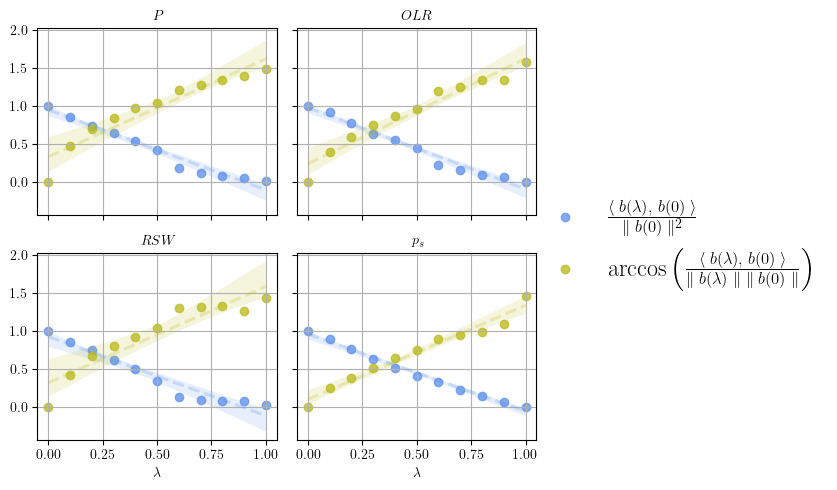

In [9]:
plt.rcParams['text.usetex'] = True

sns.set_context(rc={
    "legend.fontsize": "xx-large",
})

g = sns.FacetGrid(
    df, col="label", col_wrap=2,
    height=2.5, aspect=1.2,
    despine=False,
)

g.map_dataframe(
    sns.regplot, x=LAMBDA, y=A1, ci=95, label=A1_label,
    color="cornflowerblue",
    line_kws=dict(color="cornflowerblue", linestyle="--", alpha=0.25),
)

g.map_dataframe(
    sns.regplot, x=LAMBDA, y=A3, ci=95, label=A3_label,
    color="tab:olive", 
    line_kws=dict(color="tab:olive", linestyle="--", alpha=0.25),
)

g.set_ylabels("")
g.set_titles(col_template="{col_name}")

axs = g.axes.flatten()

for ax in axs:
    ax.grid()
    
g.add_legend()

plt.show()

In [10]:
g.savefig(os.path.join(OUTDIR, "hybrid_lambda.pdf"), bbox_inches="tight")

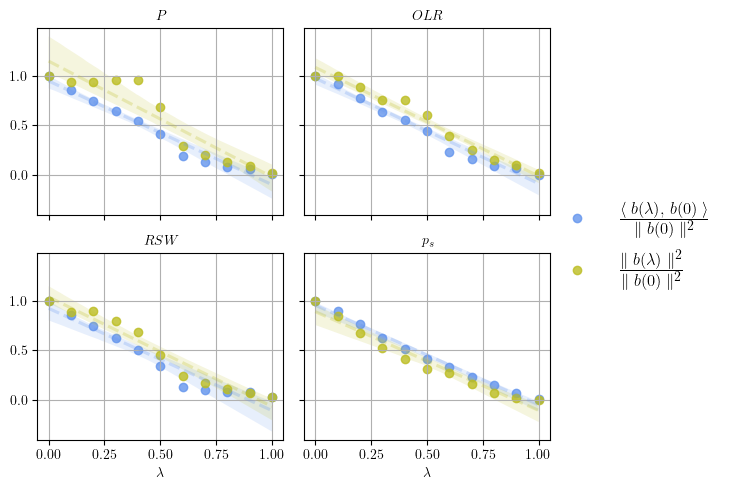

In [11]:
plt.rcParams['text.usetex'] = True

sns.set_context(rc={
    "legend.fontsize": "xx-large",
})

g = sns.FacetGrid(
    df, col="label", col_wrap=2,
    height=2.5, aspect=1.2,
    despine=False,
)

g.map_dataframe(
    sns.regplot, x=LAMBDA, y=A1, ci=95, label=A1_label,
    color="cornflowerblue",
    line_kws=dict(color="cornflowerblue", linestyle="--", alpha=0.25),
)

g.map_dataframe(
    sns.regplot, x=LAMBDA, y=A2, ci=95, label=A2_label,
    color="tab:olive", 
    line_kws=dict(color="tab:olive", linestyle="--", alpha=0.25),
)

g.set_ylabels("")
g.set_titles(col_template="{col_name}")

axs = g.axes.flatten()

for ax in axs:
    ax.grid()
    
g.add_legend()

plt.show()

In [12]:
g.savefig(os.path.join(OUTDIR, "hybrid_lambda_v2.pdf"), bbox_inches="tight")

In [13]:
lat_weights = np.cos(np.deg2rad(ds_dict[ZERO_SHOT]["lat"]))

dP0 = time_mean_bias_dict[ZERO_SHOT]

inner_prods = [
    spatial_inner_product(
        a=time_mean_bias_dict[key], b=dP0,
        area_weights=lat_weights
    ).item()
    for key in RUNS
]

norms_sq = [
    spatial_inner_product(
        a=time_mean_bias_dict[key], b=time_mean_bias_dict[key],
        area_weights=lat_weights
    ).item()
    for key in RUNS
]

AttributeError: 'Dataset' object has no attribute 'item'

In [ ]:
lat_weights = np.cos(np.deg2rad(ds_dict[ZERO_SHOT]["lat"]))

dP0 = time_mean_bias_dict[ZERO_SHOT]

denom = spatial_inner_product(dP0, dP0, area_weights=lat_weights).item()

A1_precip = [1] + [
    spatial_inner_product(
        a=time_mean_bias_dict[key], b=dP0,
        area_weights=lat_weights
    ).item() / denom
    for key in RUNS[1:]
]

A2_precip = np.sqrt([
    spatial_inner_product(
        time_mean_bias_dict[key], 
        time_mean_bias_dict[key], 
        area_weights=lat_weights
    ).item()
    for key in RUNS
]) / np.sqrt(denom)

In [ ]:
LAMBDA = "$\lambda$"
A1 = "$A1(\lambda)$"
A2 = "$A2(\lambda)$"

df_precip = pd.DataFrame.from_dict({
    LAMBDA: lambdas,
    A1: A1_precip,
    A2: A2_precip
})

df_precip

In [ ]:
ax = sns.regplot(
    data=df_precip, x=LAMBDA, y=A1, ci=95, label=A1_label,
)
_ = sns.regplot(
    data=df_precip, x=LAMBDA, y=A2, ci=95, label=A2_label, 
    marker="x", color="k", line_kws=dict(color="k", linestyle="--"), ax=ax,
)

ax.set_ylabel("")

ax.legend()

plt.show()

In [ ]:
inner_prods = [
    spatial_inner_product(
        a=time_mean_bias_dict[key], b=dP0,
        area_weights=lat_weights
    ).item()
    for key in RUNS
]

norms_sq = [
    spatial_inner_product(
        a=time_mean_bias_dict[key], b=time_mean_bias_dict[key],
        area_weights=lat_weights
    ).item()
    for key in RUNS
]

proj_lengths = [x / np.sqrt(norms_sq[0]) for i, x in enumerate(inner_prods)]
angles = [np.arccos(x / np.sqrt(norms_sq[i])) for i, x in enumerate(proj_lengths)]

A3 = "$A3(\lambda)$"
A3_label = r"$arccos \left( \frac{\langle \; dP(x, \lambda), dP(x, 0) \; \rangle}{ \| \; dP(x, \lambda) \; \| \| \; dP(x, 0) \; \|  } \right)$"

df_precip[A3] = angles
df_precip

In [ ]:
ax = sns.regplot(
    data=df_precip, x=LAMBDA, y=A1, ci=95, label=A1_label,
)
_ = sns.regplot(
    data=df_precip, x=LAMBDA, y=A3, ci=95, label=A3_label, 
    marker="x", color="k", line_kws=dict(color="k", linestyle="--"), ax=ax,
)

ax.legend()

plt.show()